In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
import mlflow
from pathlib import Path
# Ontario holidays setup
import holidays

c:\Users\elias\Documents\MLOps\mlflow_prophet_lightgbm\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_ontario_holidays(years):
    ontario_holidays = holidays.CA(prov='ON', years=years)
    return pd.DataFrame([
        {'ds': date, 'holiday': name}
        for date, name in ontario_holidays.items()
    ])

In [3]:
def evaluate_forecast(y_true, y_pred, verbose=False):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # MAE
    mae = np.mean(np.abs(y_true - y_pred))

    # SMAPE with masking
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    valid_mask = denom != 0
    smape_values = np.abs(y_true[valid_mask] - y_pred[valid_mask]) / denom[valid_mask]
    smape = np.mean(smape_values) * 100 if smape_values.size > 0 else np.nan

    if verbose:
        skipped = len(y_true) - np.count_nonzero(valid_mask)
        print(f"[SMAPE] Skipped {skipped} zero-denominator cases out of {len(y_true)}")

    return rmse, mae, smape


In [31]:

# Plotting
def plot_forecast(model, train_df, test_df, forecast_test, fold):
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    # Log-transformed
    ax[0].plot(train_df['ds'][-50:], train_df['y'][-50:], label="Train", color='steelblue')
    ax[0].plot(test_df['ds'], test_df['y'], label="Observed", color='blue')
    ax[0].plot(forecast_test.index, forecast_test['yhat'], label="Predicted", color='orange')
    ax[0].fill_between(forecast_test.index, forecast_test['yhat_lower'], forecast_test['yhat_upper'], color='red', alpha=0.2)
    ax[0].legend()
    ax[0].set_title(f"Fold {fold+1}: Prophet Prediction (log-transformed)")
    ax[0].grid(alpha=0.3)

    # Original scale
    ax[1].plot(train_df['ds'][-50:], np.expm1(train_df['y'][-50:]), label="Train", color='steelblue')
    ax[1].plot(test_df['ds'], np.expm1(test_df['y']), label="Observed", color='blue')
    ax[1].plot(forecast_test.index, np.expm1(forecast_test['yhat']), label="Predicted", color='orange')
    ax[1].legend()
    ax[1].set_title(f"Fold {fold+1}: Prophet Prediction (Original Scale)")
    ax[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # fig2 = model.plot_components(forecast_test.reset_index())

In [11]:
# MLflow logging stub
def prophet_log_model(mae_list, rmse_list, smape_list):
    with mlflow.start_run(run_name="Prophet Log"):
        mlflow.log_metric("MAE_mean", np.mean(mae_list))
        mlflow.log_metric("RMSE_mean", np.mean(rmse_list))
        mlflow.log_metric("SMAPE_mean", np.mean(smape_list))
        mlflow.log_metric("MAE_std", np.std(mae_list))
        mlflow.log_metric("RMSE_std", np.std(rmse_list))
        mlflow.log_metric("SMAPE_std", np.std(smape_list))
        mlflow.log_param("model_type", "Prophet")
        mlflow.log_param("holiday_region", "Ontario")

In [ ]:
# CV loop
def prophet_cv(df, holiday_df, n_splits=5):
    
    mae_list, rmse_list, smape_list = [], [], []
    
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=7)

    for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):
        
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        model = Prophet(
            growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            holidays=holiday_df
        )
        model.fit(train_df)

        future = model.make_future_dataframe(periods=len(test_df), freq='D')
        forecast = model.predict(future)
        forecast_test = forecast.set_index('ds').loc[test_df['ds'].values]

        rmse, mae, smape = evaluate_forecast(test_df['y'], forecast_test['yhat'])
        
        rmse_list.append(rmse)
        mae_list.append(mae)
        smape_list.append(smape)

        print(f"Fold {fold+1} MAE: {mae:.4f}, RMSE: {rmse:.4f}, SMAPE: {smape:.4f}%")
        
        plot_forecast(model, train_df, test_df, forecast_test, fold)

    return mae_list, rmse_list, smape_list

In [13]:
def load_data():
    
    # Load your time series data
    base_dir = Path().cwd().parent

    data_path = base_dir / "data" / "processed" / "daily_tickets_2022_25.parquet"

    print(f"Loading data from: {data_path}")

    data = pd.read_parquet(data_path) 
    
    return data

In [20]:
# Main entry
def main():

    data = load_data()
    data["log_transformed_redem"] = np.log1p(data["Redemption Count"])
    data["log_transformed_sales"] = np.log1p(data["Sales Count"])
    data["diff_log_redem"] = data["log_transformed_redem"].diff()
    data = data.dropna().reset_index(drop=True)

    display(data.head())
    
    df = data.copy()  # or copy original dataframe

    df = df[['Timestamp', 'log_transformed_redem', 'log_transformed_sales']].dropna()

    df.rename(columns={"Timestamp":"ds", "log_transformed_redem":"y"}, inplace=True)
    
    df['ds'] = pd.to_datetime(df['ds'])
    
    years = df['ds'].dt.year.unique()
    
    holiday_df = get_ontario_holidays(years)

    mae_list, rmse_list, smape_list = prophet_cv(df, holiday_df, n_splits=5)
    
    # prophet_log_model(mae_list, rmse_list, smape_list)

Loading data from: c:\Users\elias\Documents\MLOps\mlflow_prophet_lightgbm\data\processed\daily_tickets_2022_25.parquet


,Timestamp,Redemption Count,Sales Count,log_transformed_redem,log_transformed_sales,diff_log_redem
0,2022-01-02,345,322,5.846439,5.777652,-0.376137
1,2022-01-03,532,503,6.278521,6.222576,0.432083
2,2022-01-04,475,412,6.165418,6.023448,-0.113104
3,2022-01-05,225,201,5.420535,5.308268,-0.744883
4,2022-01-06,358,324,5.883322,5.783825,0.462787


09:53:19 - cmdstanpy - INFO - Chain [1] start processing
09:53:20 - cmdstanpy - INFO - Chain [1] done processing


Fold 1 MAE: 0.3591, RMSE: 0.4295, SMAPE: 4.4193%


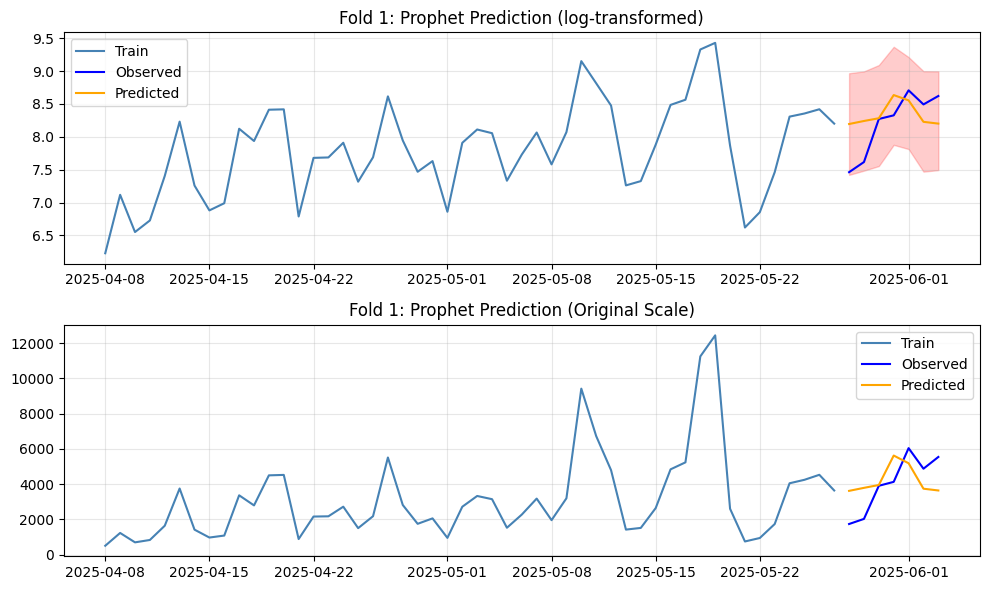

09:53:21 - cmdstanpy - INFO - Chain [1] start processing
09:53:21 - cmdstanpy - INFO - Chain [1] done processing


Fold 2 MAE: 0.4665, RMSE: 0.5324, SMAPE: 5.4053%


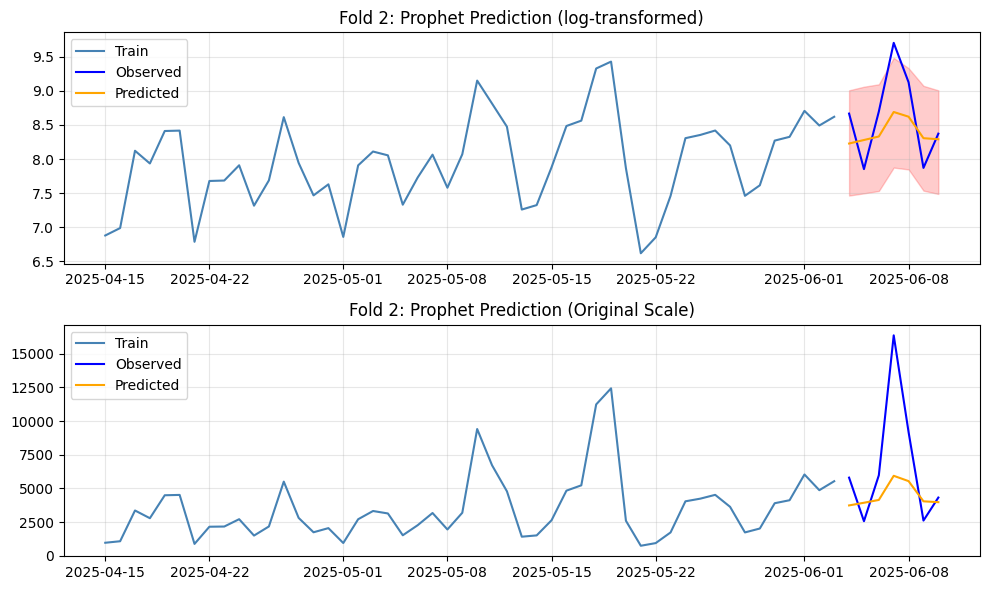

09:53:22 - cmdstanpy - INFO - Chain [1] start processing
09:53:22 - cmdstanpy - INFO - Chain [1] done processing


Fold 3 MAE: 0.3774, RMSE: 0.5008, SMAPE: 4.1914%


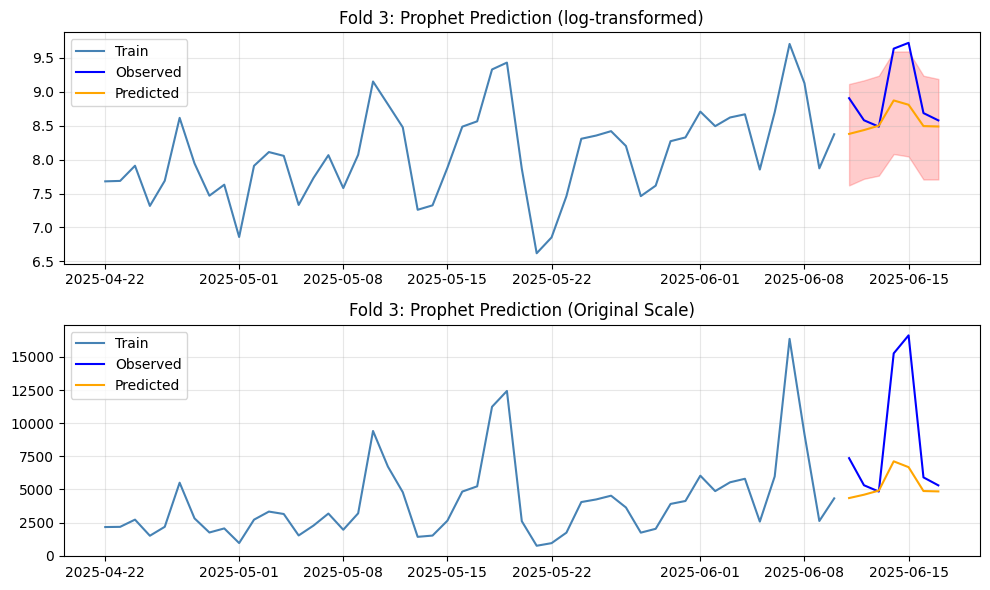

09:53:24 - cmdstanpy - INFO - Chain [1] start processing
09:53:24 - cmdstanpy - INFO - Chain [1] done processing


Fold 4 MAE: 0.3799, RMSE: 0.4314, SMAPE: 4.3547%


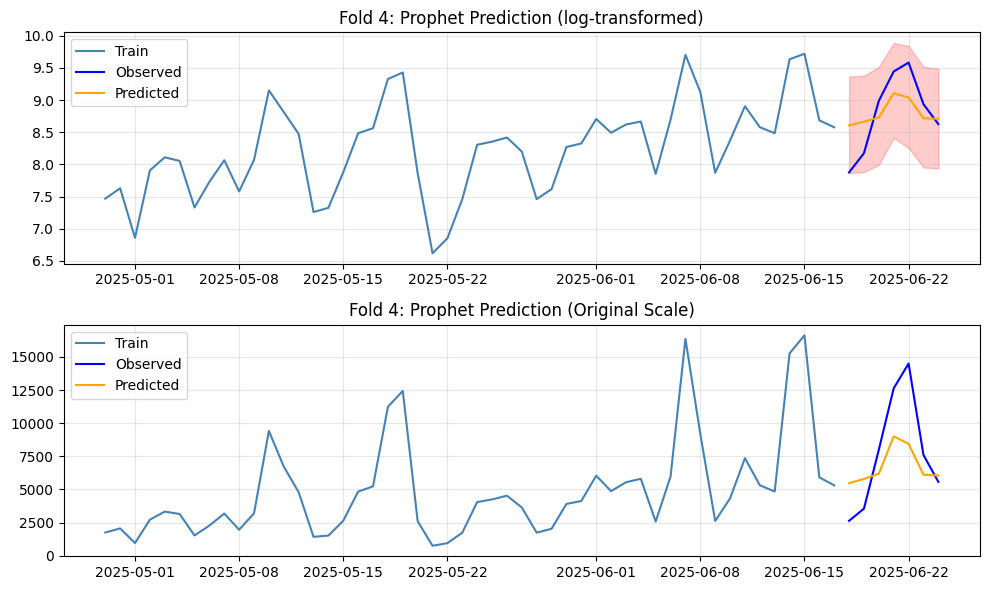

09:53:25 - cmdstanpy - INFO - Chain [1] start processing
09:53:25 - cmdstanpy - INFO - Chain [1] done processing


Fold 5 MAE: 0.3771, RMSE: 0.4023, SMAPE: 4.1430%


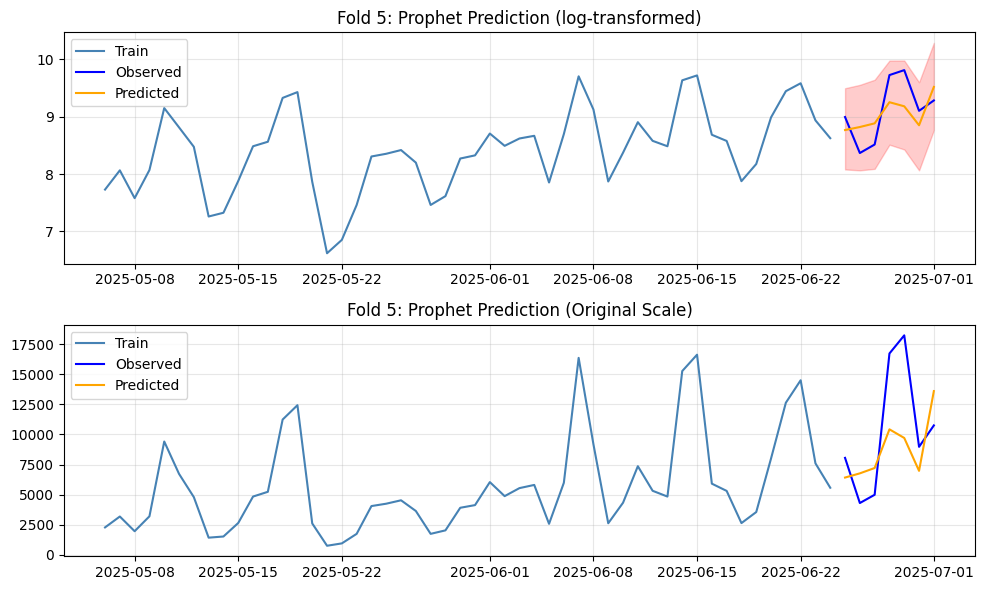

In [32]:
if __name__ == "__main__":
    main()